In [1]:
import sys

#sys.path.insert(0, 'backend_functions')

#import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

from matplotlib import gridspec


Welcome to JupyROOT 6.24/02


In [2]:
ending = "Sept19_MECTune"

In [3]:
##Regular tune prior true and smearcept to be used


#Recall for comparison it will be the MEC tune for prior true

In [3]:
####Load in MECTune full event counts

nue_data_signal = pd.read_csv("nue_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

nue_data_signal = nue_data_signal.values[:, 0]

print(nue_data_signal)
print("")

######

numu_data_signal = pd.read_csv("numu_full_500_catsel_nopions_angleDiff_usingSelection_full_evt_count_MCONLY_recoCut_comb_"+ending+".csv", header=None)

numu_data_signal = numu_data_signal.values[:, 0]

print(numu_data_signal)

[  1.77632306   2.07830911   3.2206118    4.81568623   7.07287881
   8.30788006  12.11347374  20.41717936  38.83475028 112.39554039]

[  54.8327077    43.54171195   58.82038724   75.0084432    86.26122895
  144.09051796  200.96945792  306.25222223  562.35712383 1086.78692855]


In [4]:
###Load in regular tune bkg event counts
#Include ext in bkg count here as the full event counts do

ending = "Sept19" #need this ending as bkg is from regular tune



nue_bkg_inc_ext = pd.read_csv("nue_nopions_angleDiff_usingSelection_comb_cv_nue_bkg_incExt_"+ending+".csv", header=None)

nue_bkg_inc_ext = nue_bkg_inc_ext.values[:, 0]

print(nue_bkg_inc_ext)
print("")

#######################

numu_bkg_inc_ext = pd.read_csv("numu_nopions_angleDiff_usingSelection_comb_cv_numu_bkg_incExt_"+ending+".csv", header=None)

numu_bkg_inc_ext = numu_bkg_inc_ext.values[:, 0]

print(numu_bkg_inc_ext)
print("")

[0.51361159 0.08107165 1.07782759 1.36931295 0.98017368 1.39234907
 0.93315394 1.31949028 2.35920892 8.64089253]

[ 19.27203889  12.25157685  12.37824308  12.0903731   18.01790853
  33.14119786  50.8837206   78.09110185 143.26644553 284.66838148]



In [5]:
####So then can calculate the data signal input to the unfolding

nue_datasig_bkg_subtracted = nue_data_signal - nue_bkg_inc_ext
print(nue_datasig_bkg_subtracted)
print("")

numu_datasig_bkg_subtracted = numu_data_signal - numu_bkg_inc_ext
print(numu_datasig_bkg_subtracted)

[  1.26271148   1.99723746   2.14278421   3.44637328   6.09270513
   6.91553099  11.18031981  19.09768908  36.47554136 103.75464786]

[ 35.5606688   31.29013511  46.44214416  62.91807009  68.24332042
 110.94932011 150.08573732 228.16112038 419.0906783  802.11854707]


In [6]:
nue_numu_tot = np.concatenate((nue_datasig_bkg_subtracted, numu_datasig_bkg_subtracted), axis=0)

print(nue_numu_tot)
print(len(nue_numu_tot))

[  1.26271148   1.99723746   2.14278421   3.44637328   6.09270513
   6.91553099  11.18031981  19.09768908  36.47554136 103.75464786
  35.5606688   31.29013511  46.44214416  62.91807009  68.24332042
 110.94932011 150.08573732 228.16112038 419.0906783  802.11854707]
20


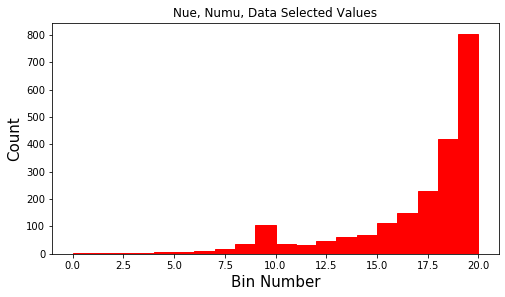

In [7]:
nue_numu_fig = plt.figure(figsize=(8, 7))
nue_numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_numu_ax1 = plt.subplot(nue_numu_gs[0])


#bins = np.arange(0, 10.5, 0.5)
#count = np.linspace(0.1, 9.6, 20)
bins = np.arange(0, 21, 1)
count = np.arange(0.0, 20.0, 1)


sel_ratio = nue_numu_ax1.hist(count, bins, edgecolor='red', facecolor='red', weights=nue_numu_tot)
nue_numu_ax1.set_ylabel('Count', fontsize=15)
nue_numu_ax1.set_xlabel('Bin Number', fontsize=15)
nue_numu_ax1.set_title("Nue, Numu, Data Selected Values")
#leg = nue_numu_ax1.legend()
#nue_numu_ax1.set_ylim([0, 1])

nue_numu_fig.savefig("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

In [8]:
np.savetxt("data_signal_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
               nue_numu_tot,
               delimiter =", ", 
               fmt ='% s')

print(ending)

Sept19


In [9]:
####Now need to get in the uncertainties

###First up, get the noTune statistical uncertinaty. This will be from sig + bkg in noTune

ending = "Sept19_MECTune" 


nue_sig_unc = pd.read_csv("nue_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

nue_sig_unc = nue_sig_unc.values[:, 0]

print(nue_sig_unc)
print("")

########################

numu_sig_unc = pd.read_csv("numu_total_noTune_err_squared_angle_comb_"+ending+".csv", header=None)

numu_sig_unc = numu_sig_unc.values[:, 0]

print(numu_sig_unc)
print("")

#######################The regular tune bkg stat uncertainties

ending = "Sept19" #need this ending as bkg is from regular tune


nue_bkg_unc = pd.read_csv("nue_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

nue_bkg_unc = nue_bkg_unc.values[:, 0]

print(nue_bkg_unc)
print("")

########################

numu_bkg_unc = pd.read_csv("numu_bkg_exp_err_squared_angle_comb_"+ending+".csv", header=None)

numu_bkg_unc = numu_bkg_unc.values[:, 0]

print(numu_bkg_unc)
print("")

[ 0.40068212  0.0506208   0.99776155  1.29064932  0.85994147  1.07949615
  0.82158983  1.30638069  2.24751467 10.66035193]

[  17.0648928    11.53346254   22.22430568   34.18778579   27.00759133
  112.14390869  124.33691391  207.96111837  462.90081792 1364.47034051]

[3.12590139e-01 9.13221298e-04 9.28808735e-01 1.18168833e+00
 6.23592227e-01 9.34778774e-01 3.17893291e-01 3.24428966e-01
 4.19916543e-02 9.97373119e-01]

[ 5.11845584  3.09268746  4.92119789  3.65029054  6.31709052 15.80961473
 21.84007035 29.2605047  39.40834823 71.64688123]



In [10]:
nue_stat_unc = nue_sig_unc + nue_bkg_unc
print(nue_stat_unc)
print("")

########################

numu_stat_unc = numu_sig_unc + numu_bkg_unc
print(numu_stat_unc)
print("")

#########################

nue_numu_tot_unc = np.concatenate((nue_stat_unc, numu_stat_unc), axis=0)

print(nue_numu_tot_unc)

[ 0.71327226  0.05153402  1.92657028  2.47233766  1.4835337   2.01427492
  1.13948313  1.63080966  2.28950633 11.65772505]

[  22.18334865   14.62614999   27.14550357   37.83807633   33.32468185
  127.95352342  146.17698426  237.22162307  502.30916615 1436.11722175]

[7.13272258e-01 5.15340249e-02 1.92657028e+00 2.47233766e+00
 1.48353370e+00 2.01427492e+00 1.13948313e+00 1.63080966e+00
 2.28950633e+00 1.16577250e+01 2.21833486e+01 1.46261500e+01
 2.71455036e+01 3.78380763e+01 3.33246819e+01 1.27953523e+02
 1.46176984e+02 2.37221623e+02 5.02309166e+02 1.43611722e+03]


In [11]:
nue_numu_cov_stats   = np.zeros([(len(bins)-1), (len(bins)-1)])
print(nue_numu_cov_stats)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [12]:
nue_numu_cov_stats[np.diag_indices_from(nue_numu_cov_stats)]    = nue_numu_tot_unc

In [13]:
###Then sprinkle in the regular tune genie sys uncertainties

# Load in the blockwise genie cov matrix

blockwise_genie_err = pd.read_csv("blockwise_cov_genie_only_angle_comb_"+ending+".csv", header=None)

blockwise_genie_err = blockwise_genie_err.values
print(blockwise_genie_err)

[[ 4.70583959e-02  5.83849171e-02  5.61014397e-02  9.20960299e-02
   1.36589167e-01  1.73094762e-01  2.75917564e-01  4.49749677e-01
   8.70289529e-01  2.25159104e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.83849171e-02  1.20315655e-01  1.01685021e-01  1.56689092e-01
   2.10322153e-01  3.52851000e-01  3.68263749e-01  5.86677240e-01
   6.53303092e-01 -4.92231404e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.61014397e-02  1.01685021e-01  9.52768338e-02  1.48528569e-01
   2.08623175e-01  3.25244455e-01  3.77692933e-01  6.13574244e-01
   8.90230789e-01  8.89390034e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.20

In [14]:
##### Now make the total cov matrix

total_noTune_input_cov = nue_numu_cov_stats + blockwise_genie_err

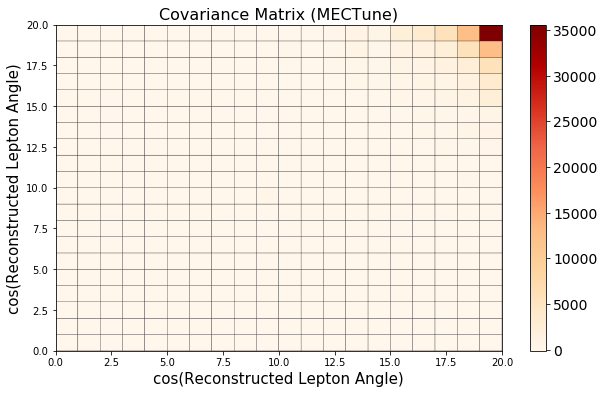

In [15]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, total_noTune_input_cov, cmap='OrRd', edgecolors='k')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
#if pot: 
#    cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

plt.xlim(bins[0], bins[-1])
plt.ylim(bins[0], bins[-1])


plt.xlabel("cos(Reconstructed Lepton Angle)", fontsize=15)
plt.ylabel("cos(Reconstructed Lepton Angle)", fontsize=15)

plt.title('Covariance Matrix (MECTune)', fontsize=16)


plt.savefig("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".svg", bbox_inches='tight')

plt.show()

In [16]:
np.savetxt("data_covmat_MC_MECTune_input_angleDiff_comb_"+ending+".csv", 
           total_noTune_input_cov,
           delimiter =", ", 
           fmt ='% s')